In [1]:
import pandas as pd
import nltk
import wordninja
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer  
import preprocessor as p
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import warnings
from datetime import datetime
from tqdm import tqdm
import textblob

warnings.filterwarnings('ignore')
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION)

In [2]:
spell = SpellChecker()
lemmatizer = WordNetLemmatizer()
sid_obj = SentimentIntensityAnalyzer()

In [3]:
df = pd.read_csv('tweets_en_2016_2019.csv')

In [4]:
df.head()

,user,timestamp,replies,likes,retweets,text,tweet_lang,date
0,ProjectCoin,2016-01-01 07:54:18+00,0.0,0.0,1.0,LIVE: Profit = $419.17 (4.99 %). BUY B20.42 @ ...,en,2016-01-01
1,ProjectCoin,2016-01-01 08:29:20+00,0.0,0.0,1.0,"In the last 10 mins, there were arb opps spann...",en,2016-01-01
2,BTCtoUSD,2016-01-01 04:20:03+00,0.0,0.0,1.0,Current price: 435.15$ $BTCUSD $btc #bitcoin 2...,en,2016-01-01
3,BTCtoUSD,2016-01-01 09:00:06+00,0.0,0.0,0.0,Current price: 432$ $BTCUSD $btc #bitcoin 2016...,en,2016-01-01
4,BTCticker,2016-01-01 12:00:04+00,0.0,0.0,0.0,One Bitcoin now worth $432.09@bitstamp. High $...,en,2016-01-01


In [5]:
def data_cleaning(text):
    text = re.sub('https.*', '', text)
    text = re.sub('@*', '', text)
    text = re.sub('\n', '', text)
    return text

def alt_data_cleaning(text):
    try:
        res = p.clean(text)
    except:
        res = ''
    return text

def vader(text):
    sentiment_dict = sid_obj.polarity_scores(text)
    scores = [sentiment_dict['neg']*100, sentiment_dict['neu']*100, sentiment_dict['pos']*100]
    sent_dict = {0:'negative', 1:'neutral', 2:'positive'}
    neg = scores[0]
    neu = scores[1]
    pos = scores[2]
    sent = sent_dict[scores.index(max(scores))]
    return neg, neu, pos, sent

def textblob_sentiment(text):
    sent_analysis = textblob.TextBlob(text)
    if sent_analysis.sentiment.polarity ==0:
        return 'neutral'
    elif sent_analysis.sentiment.polarity > 0.00:
        return 'positive'
    elif sent_analysis.sentiment.polarity < 0.00:
        return 'negative'
    return ''

In [6]:
df['text'] = df['text'].map(lambda x: data_cleaning(x))
df['text'] = df['text'].map(lambda x: alt_data_cleaning(x))

In [7]:
neglist, neulist, poslist, sentlist = [], [], [], []

for row in tqdm(df.itertuples()):
    text = row[6]
    neg, neu, pos, sent = vader(text)
    neglist.append(neg)
    neulist.append(neu)
    poslist.append(pos)
    sentlist.append(sent)

2334685it [02:41, 14458.06it/s]


In [8]:
df['neg_sent'] = neglist
df['neu_sent'] = neulist
df['pos_sent'] = poslist
df['sentiment'] = sentlist

In [9]:
textbloblist = []

for row in tqdm(df.itertuples()):
    text = row[6]
    textblob_sent = textblob_sentiment(text)
    textbloblist.append(textblob_sent)

df['textblob_sentiment'] = textbloblist

2334685it [06:20, 6132.25it/s] 


In [10]:
df.head()

,user,timestamp,replies,likes,retweets,text,tweet_lang,date,neg_sent,neu_sent,pos_sent,sentiment,textblob_sentiment
0,ProjectCoin,2016-01-01 07:54:18+00,0.0,0.0,1.0,LIVE: Profit = $419.17 (4.99 %). BUY B20.42 $...,en,2016-01-01,0.0,84.7,15.3,neutral,positive
1,ProjectCoin,2016-01-01 08:29:20+00,0.0,0.0,1.0,"In the last 10 mins, there were arb opps spann...",en,2016-01-01,0.0,87.9,12.1,neutral,neutral
2,BTCtoUSD,2016-01-01 04:20:03+00,0.0,0.0,1.0,Current price: 435.15$ $BTCUSD $btc #bitcoin 2...,en,2016-01-01,0.0,100.0,0.0,neutral,neutral
3,BTCtoUSD,2016-01-01 09:00:06+00,0.0,0.0,0.0,Current price: 432$ $BTCUSD $btc #bitcoin 2016...,en,2016-01-01,0.0,100.0,0.0,neutral,neutral
4,BTCticker,2016-01-01 12:00:04+00,0.0,0.0,0.0,One Bitcoin now worth $432.09bitstamp. High $4...,en,2016-01-01,11.7,77.8,10.6,neutral,positive


In [11]:
df['sentiment'].value_counts()

neutral     2307461
positive      16794
negative      10430
Name: sentiment, dtype: int64

In [12]:
df['textblob_sentiment'].value_counts()

neutral     1446022
positive     675201
negative     213462
Name: textblob_sentiment, dtype: int64

In [13]:
#df.to_csv('../data/tweets_en_2016_2019_sentiment.csv', index=False)

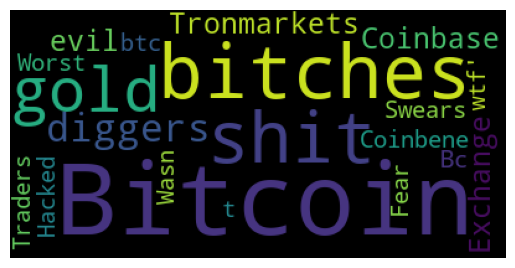

In [14]:
#Negative words
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = df[df['sentiment'] == 'negative']['text'].values 
wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

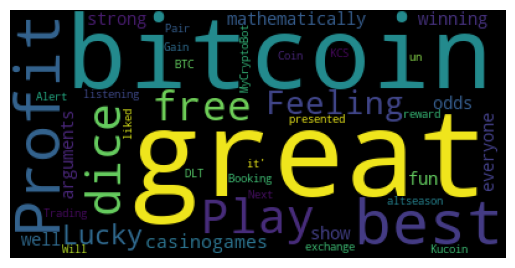

In [15]:
#Positive words
text = df[df['sentiment'] == 'positive']['text'].values 
wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

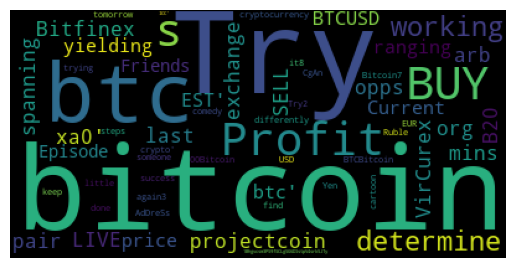

In [16]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = df[df['sentiment'] == 'neutral']['text'].values 
wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

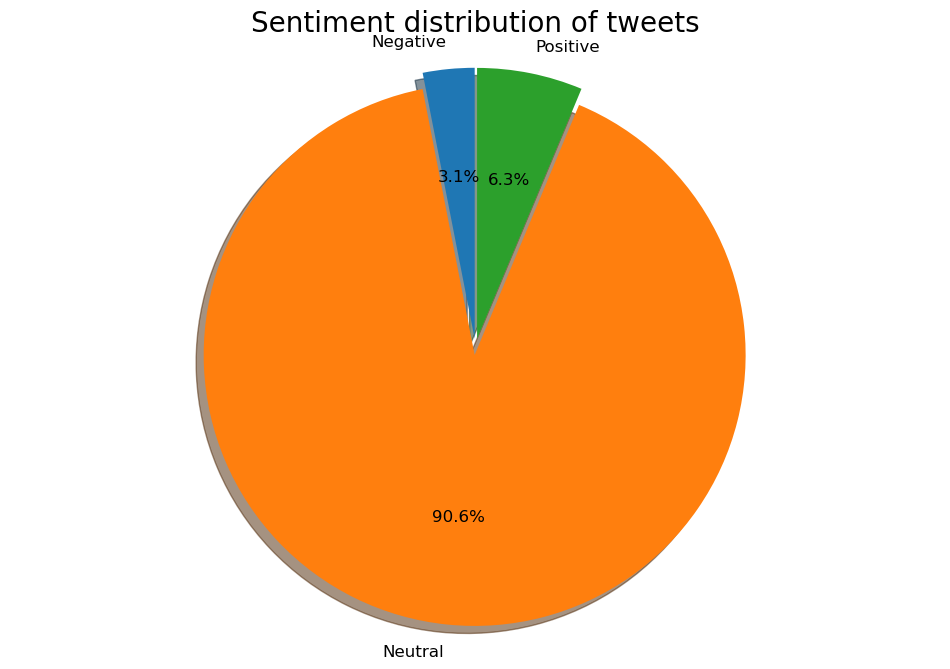

In [17]:
import matplotlib.pyplot as plt
negative_perc=round(sum(df['neg_sent'])/df['neg_sent'].shape[0],2)
neutral_perc=round(sum(df['neu_sent'])/df['neu_sent'].shape[0],2)
positive_perc=round(sum(df['pos_sent'])/df['pos_sent'].shape[0],2)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Negative', 'Neutral', 'Positive']

negative_perc,neutral_perc,positive_perc

sizes = negative_perc,neutral_perc,positive_perc
explode = (0.03, 0.03, 0.03)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
fig1.set_size_inches(12, 8)
plt.title('Sentiment distribution of tweets',fontsize=20)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,textprops={'fontsize': 12})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()